In [61]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [62]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [63]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [64]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [65]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base

C:\Users\joshs\AppData\Local\Temp\ipykernel_25724\2310722441.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


sqlalchemy.ext.automap.Base

In [66]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [67]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [68]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [69]:

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [70]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [71]:
print(measurement)
print(station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [72]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [73]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement.date)).scalar()
print(f'The most recent date is {recent_date}')

The most recent date is 2017-08-23


In [74]:
one_year_ago = pd.to_datetime(recent_date) - pd.DateOffset(years=1)
print(one_year_ago)

2016-08-23 00:00:00


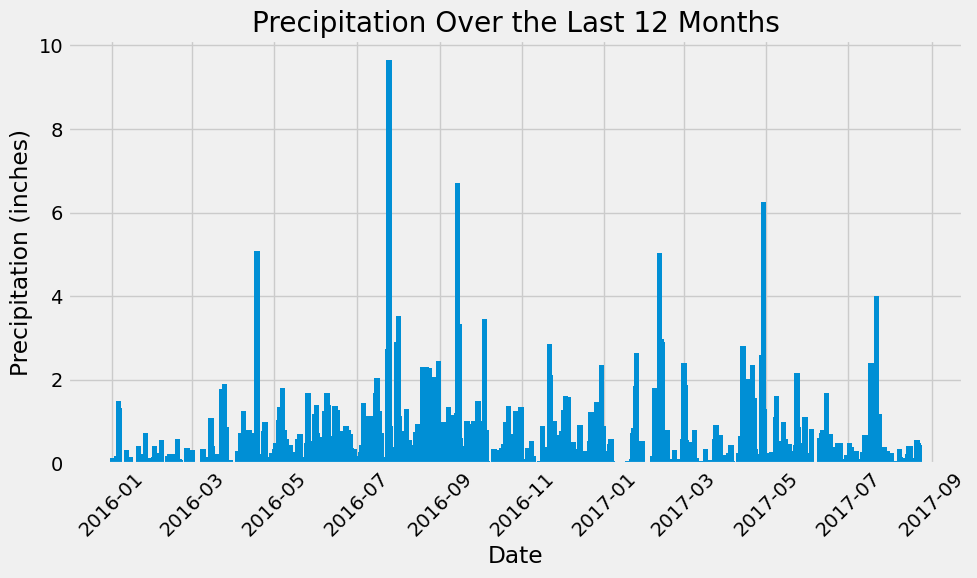

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = session.query(func.max(measurement.date)).scalar()
# Calculate the date one year from the last date in data set.
one_year_ago = pd.to_datetime(recent_date) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= 2016)
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'])
precipitation_df = precipitation_df.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate summary statistics for precipitation data
summary_mean = precipitation_df['Precipitation'].mean()
summary_median = precipitation_df['Precipitation'].median()

In [ ]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
print(summary_statistics)


count    3336.000000
mean        0.174559
std         0.487085
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         9.640000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(total_stations)

9


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
#for i, x in active_stations:
    #print (f"Station ID: {i}, Count: {x}")
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [78]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
for min_temps, max_temp, avg_temp in temperature_stats:
    print(f"Lowest Temp: {min_temps}")
    print(f"Highest Temp: {max_temp}")
    print(f"Average Temp: {avg_temp}")

Lowest Temp: 54.0
Highest Temp: 85.0
Average Temp: 71.66378066378067


Text(0.5, 1.0, 'Temperature Observations for Most Active Station Since 2016')

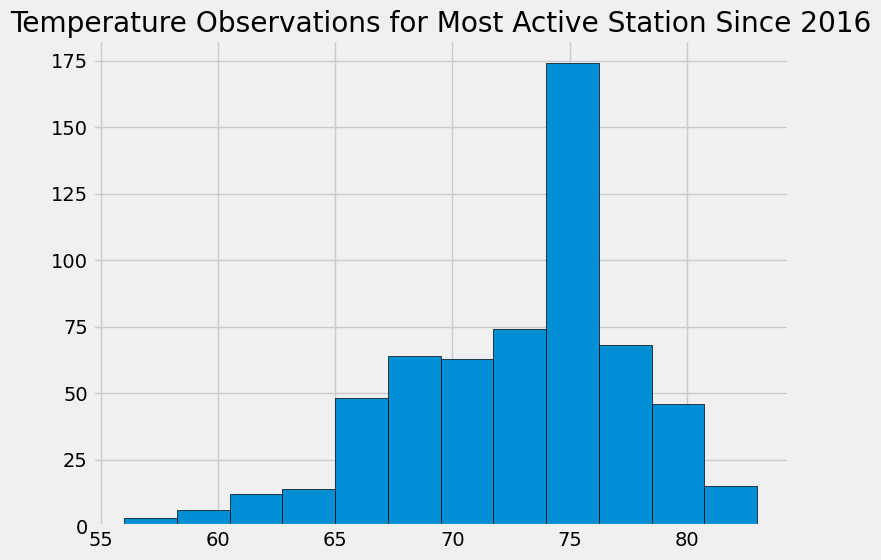

In [83]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= 2016).all()
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'tobs'])
plt.figure(figsize=(8, 6))
plt.hist(temperature_df['tobs'], bins=12, edgecolor='black')
plt.title("Temperature Observations for Most Active Station Since 2016")

# Close Session

In [ ]:
# Close Session
session.close()